In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics import MeanAbsolutePercentageError
 



/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/2453605707.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/2453605707.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

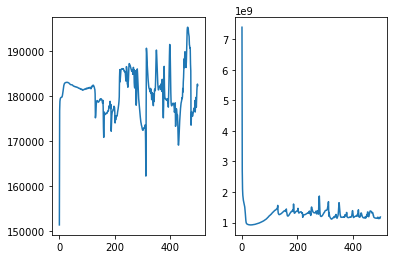

In [4]:
data = pd.read_csv("./6_24months_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
# loss_fn = nn.L1Loss()  # mean square error
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 500   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)

plt.show()


/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/2048113753.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/2048113753.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
MAE: 23419.81


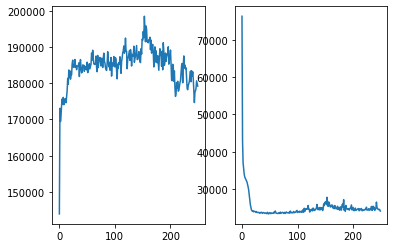

In [5]:
data = pd.read_csv("./6_24months_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
loss_fn = nn.L1Loss()  # mean square error
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 250   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MAE: %.2f" % best_mse)
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)

plt.show()


/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/3540348638.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/3540348638.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
MAPE: 0.13


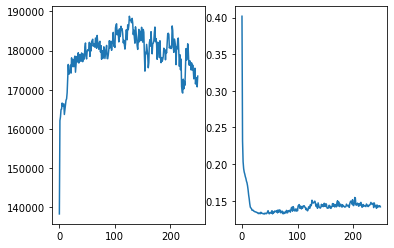

In [6]:
data = pd.read_csv("./6_24months_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
# loss_fn = nn.L1Loss()  # mean square error
# loss_fn = nn.MSELoss()
loss_fn = MeanAbsolutePercentageError()

optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 250   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MAPE: %.2f" % best_mse)
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)

plt.show()

/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/1361951291.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/1361951291.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
MSE: 1037080512.00
RMSE: 32203.73


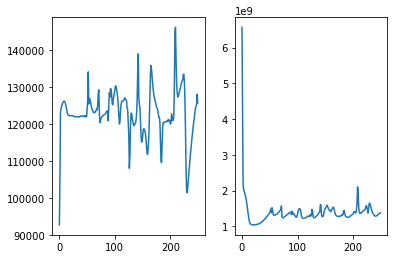

In [7]:
data = pd.read_csv("./144_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
# loss_fn = nn.L1Loss()  # mean square error
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 250   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)
plt.show()



/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/3871853524.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/3871853524.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
MAE: 24836.68


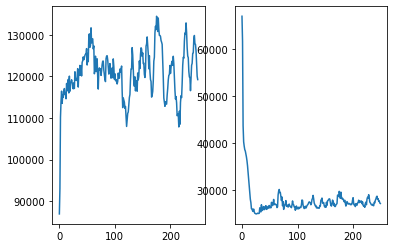

In [8]:
data = pd.read_csv("./144_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
loss_fn = nn.L1Loss()  # mean square error
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 250   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MAE: %.2f" % best_mse)
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)
plt.show()


/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/1341119797.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
/var/folders/pc/6ptp7l_n5dv0mgqvds_4y2fr0000gn/T/ipykernel_5057/1341119797.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
MAPE: 0.19


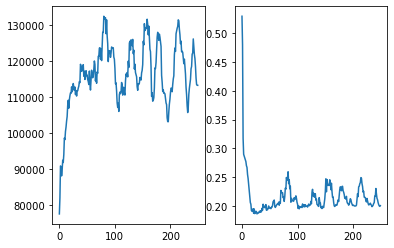

In [9]:
data = pd.read_csv("./144_US_car_data.csv")
# data = pd.read_csv("./6_24months_mldata.csv")
# data = pd.read_csv("./72_onlinemldata.csv")
# data = pd.read_csv("./144_mldata.csv.csv")


#code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
target_df = data['profit']
target = torch.tensor(target_df)
predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
n_cols = predictors.shape[1]
 

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(n_cols, 800),
    nn.ReLU(),
    nn.Linear(800, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)
# for param in model.parameters():
#     param.requires_grad = True
# loss function and optimizer
# loss_fn = nn.L1Loss()  # mean square error
# loss_fn = nn.MSELoss()
loss_fn = MeanAbsolutePercentageError()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 250   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
predictions = []
 
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    predictions.append(np.mean(y_pred.detach().numpy()))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
new_pred = model(X_test)
print("MAPE: %.2f" % best_mse)
plt.subplot(1, 2, 1)
plt.plot(predictions)
plt.subplot(1, 2, 2)
plt.plot(history)
plt.show()


In [10]:
# data = pd.read_csv("./144_car_data.csv")



# #code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
# target_df = data['profit']
# target = torch.tensor(target_df)
# predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
# scaler = StandardScaler()
# scaler.fit(X_train_raw)
# X_train = scaler.transform(X_train_raw)
# X_test = scaler.transform(X_test_raw)
# n_cols = predictors.shape[1]
 

# # Convert to 2D PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# # Define the model
# model = nn.Sequential(
#     nn.Linear(n_cols, 800),
#     nn.ReLU(),
#     nn.Linear(800, 400),
#     nn.ReLU(),
#     nn.Linear(400, 200),
#     nn.ReLU(),
#     nn.Linear(200, 1)
# )
# # for param in model.parameters():
# #     param.requires_grad = True
# # loss function and optimizer
# loss_fn = nn.L1Loss()  # mean square error
# # loss_fn = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# n_epochs = 250  # number of epochs to run
# batch_size = 10  # size of each batch
# batch_start = torch.arange(0, len(X_train), batch_size)
 
# # Hold the best model
# best_mse = np.inf   # init to infinity
# best_weights = None
# history = []
# predictions = []
 
# for epoch in range(n_epochs):
#     print(epoch)
#     model.train()
#     with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for start in bar:
#             # take a batch
#             X_batch = X_train[start:start+batch_size]
#             y_batch = y_train[start:start+batch_size]
#             # forward pass
#             y_pred = model(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             # update weights
#             optimizer.step()
#             # print progress
#             bar.set_postfix(mse=float(loss))
#     # evaluate accuracy at end of each epoch
#     model.eval()
#     y_pred = model(X_test)
#     mse = loss_fn(y_pred, y_test)
#     mse = float(mse)
#     history.append(mse)
#     if mse < best_mse:
#         best_mse = mse
#         best_weights = copy.deepcopy(model.state_dict())

# # restore model and return best accuracy
# model.load_state_dict(best_weights)
# new_pred = model(X_test)
# print(new_pred)
# print("MAE: %.2f" % best_mse)
# plt.subplot(1, 2, 1)
# plt.plot(predictions)
# plt.subplot(1, 2, 2)
# plt.plot(history)
# plt.show()

In [11]:
# data = pd.read_csv("./144_car_data.csv")



# #code adapted from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
# target_df = data['profit']
# target = torch.tensor(target_df)
# predictors = torch.tensor(data.drop(['profit'], axis=1).to_numpy(dtype=np.float64))
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)
# scaler = StandardScaler()
# scaler.fit(X_train_raw)
# X_train = scaler.transform(X_train_raw)
# X_test = scaler.transform(X_test_raw)
# n_cols = predictors.shape[1]
 

# # Convert to 2D PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# # Define the model
# model = nn.Sequential(
#     nn.Linear(n_cols, 800),
#     nn.ReLU(),
#     nn.Linear(800, 400),
#     nn.ReLU(),
#     nn.Linear(400, 200),
#     nn.ReLU(),
#     nn.Linear(200, 1)
# )
# # for param in model.parameters():
# #     param.requires_grad = True
# # loss function and optimizer
# # loss_fn = nn.L1Loss()  # mean square error
# # loss_fn = nn.MSELoss()
# loss_fn = MeanAbsolutePercentageError()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# n_epochs = 250  # number of epochs to run
# batch_size = 10  # size of each batch
# batch_start = torch.arange(0, len(X_train), batch_size)
 
# # Hold the best model
# best_mse = np.inf   # init to infinity
# best_weights = None
# history = []
 
# for epoch in range(n_epochs):
#     print(epoch)
#     model.train()
#     with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for start in bar:
#             # take a batch
#             X_batch = X_train[start:start+batch_size]
#             y_batch = y_train[start:start+batch_size]
#             # forward pass
#             y_pred = model(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             # update weights
#             optimizer.step()
#             # print progress
#             bar.set_postfix(mse=float(loss))
#     # evaluate accuracy at end of each epoch
#     model.eval()
#     y_pred = model(X_test)
#     mse = loss_fn(y_pred, y_test)
#     mse = float(mse)
#     history.append(mse)
#     if mse < best_mse:
#         best_mse = mse
#         best_weights = copy.deepcopy(model.state_dict())

# # restore model and return best accuracy
# model.load_state_dict(best_weights)
# new_pred = model(X_test)
# print(new_pred)
# print("MAPE: %.2f" % best_mse)
# plt.subplot(1, 2, 1)
# plt.plot(predictions)
# plt.subplot(1, 2, 2)
# plt.plot(history)
# plt.show()